In [0]:
#Code to keep colab running
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

In [0]:
! pip install livelossplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -qq drive/My\ Drive/data_balanced.zip

In [4]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np

np.random.seed(7)

train_data = pd.read_csv('https://raw.githubusercontent.com/pimonteiro/Covid-19-Detector/master/dataset/train_split_v3_augmented.csv', sep=',', index_col=0)
print(train_data.head())


test_data = pd.read_csv('https://raw.githubusercontent.com/pimonteiro/Covid-19-Detector/master/dataset/test_split_v3.txt', header=None, sep=' ', names=['id','image', 'result', 'type1', 'type2'])
test_data.head(1)

image_height = 224 #150
image_width = 224 #150

Using TensorFlow backend.


                                     id  ... type2
0  21e403ae-139b-4419-b3fa-0bf13d97d245  ...   NaN
1  5458205b-c67a-44de-a1e3-009f977b4f98  ...   NaN
2  4769fa12-e694-48ce-ad4e-0628e5dd75f0  ...   NaN
3  c8b05677-ce24-4967-a152-3602c5332c4c  ...   NaN
4  d8fe9c83-74df-4ca8-8075-012b6f1076bc  ...   NaN

[5 rows x 5 columns]


In [6]:
print(train_data['result'].unique())
train_data[train_data['result'] == 'COVID-19'].count()

['normal' 'pneumonia' 'COVID-19']


id         223
image     1561
result    1561
type1      196
type2       27
dtype: int64

In [5]:
print(test_data['result'].unique())
test_data[test_data['result'] == 'COVID-19'].count()

['pneumonia' 'COVID-19' 'normal']


id        31
image     31
result    31
type1     31
type2      8
dtype: int64

In [7]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32 #10

train_generator = ImageDataGenerator(
    rescale=1/255
)

test_generator = ImageDataGenerator(
    rescale=1/255
)

train_set = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='image',
    directory="train/",
    y_col='result',
    shuffle=True,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)

Found 4961 validated image filenames belonging to 3 classes.
Found 1510 validated image filenames belonging to 3 classes.


## Analysing Data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


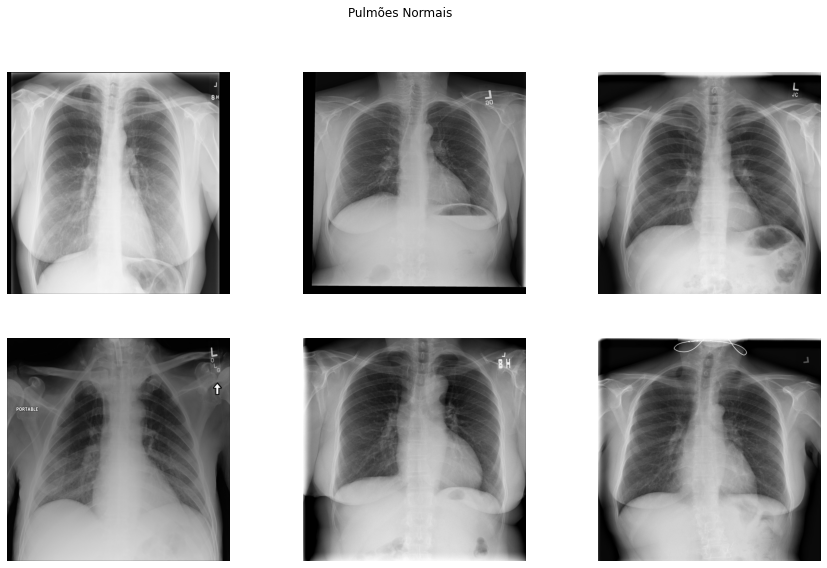

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'normal']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  print(im.shape)
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Pulmões Normais')
plt.show()

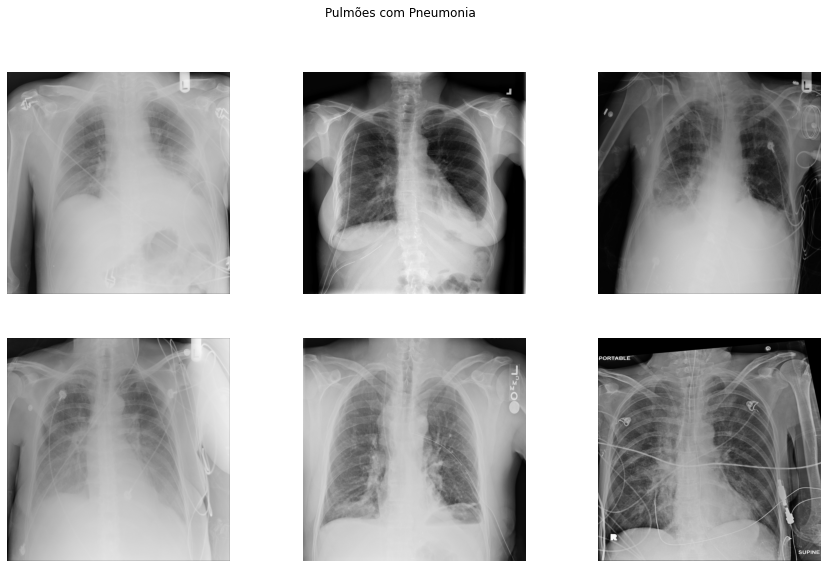

In [9]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'pneumonia']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Pulmões com Pneumonia')
plt.show()

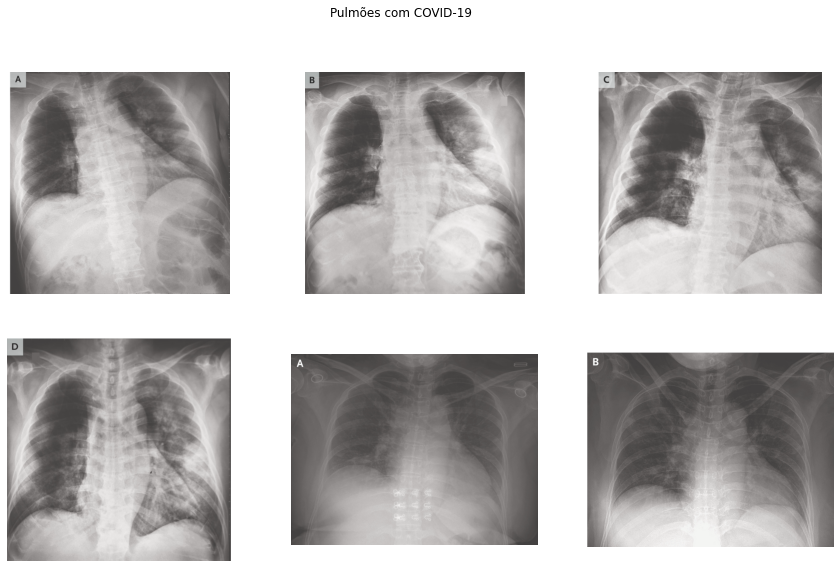

In [10]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'COVID-19']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Pulmões com COVID-19')
plt.show()

<Figure size 432x288 with 0 Axes>

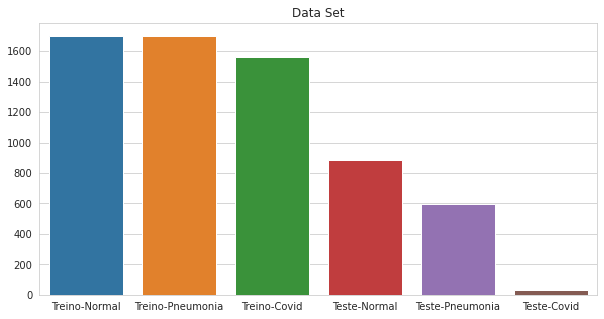

In [11]:
sns.set_style('whitegrid')
plt.figure()
plt.subplots(figsize=(10,5))
grafico=sns.barplot(x=['Treino-Normal','Treino-Pneumonia','Treino-Covid','Teste-Normal','Teste-Pneumonia','Teste-Covid'],
                    y=[train_data[train_data['result'] == 'normal'].shape[0],
                       train_data[train_data['result'] == 'pneumonia'].shape[0],
                       train_data[train_data['result'] == 'COVID-19'].shape[0],
                       test_data[test_data['result'] == 'normal'].shape[0],
                       test_data[test_data['result'] == 'pneumonia'].shape[0],
                       test_data[test_data['result'] == 'COVID-19'].shape[0]
                    ]) 
grafico.set_title('Data Set')
plt.show()

# Developing model

## Auxiliary Functions

In [0]:
import os

def save_model_on_cloud(model,name,ind):
  path="/content/drive/My Drive/covid_runs/run"+ind
  os.makedirs(path)
  model.save_weights(path + "/last_run" + name + ".hdf5")
  json_model = model.to_json()
  with open(path + "/" + name + ".json", "w") as json_file:
    json_file.write(model_json)
  os.rename("best_weights_" + name + ".hdf5", path + "/best_weights_" + name + ".hdf5")

In [0]:
from keras.models import model_from_json
import json

def load_model_from_cloud(model_path, weights_path):
  with open(model_path, 'r') as json_file:
    architecture  = json.load(json_file)
    model = model_from_json(json.dumps(architecture))
  model.load_weights(weights_path)
  return model

In [0]:
import cv2
def query_model(model, img):
  tmp_image = cv2.imread(img)
  tmp_image = np.array(tmp_image)
  tmp_image = cv2.resize(tmp_image, (image_width, image_height))
  tmp_image = tmp_image / 255
  res = model.predict(np.expand_dims(tmp_image, axis=0))
  print(test_set.class_indices)
  ind = np.argmax(res)
  print(ind)
  print([t * 100 for t in res])

## **Convolutional Neural Network Model**

<br/>

This notebook features a training network with a **LeNet** architecture.



**This architecture consists:**

- Two sets: *Convolutional Layers* and *Pooling Layers*
- One *Flattening Convolution Layer*
- Two *Fully-Connected Layers*
- A *softmax* classificator

**However, the final *Convolutionals Neurals Networks* have some improvements over this architecture:**

- Two filters 3x3 instead a filter 5x5
- Changed the *Pooling Layers* when we defined the *Convolutional Layer* with *stride* 2
- Have a *Pooling Layers* with learning ability
- Used *relu* instead *sigmoid*
- Added *Batch Normalization*
- Added *Dropout*


In [0]:
import tensorflow as tf
##from tensorflow import keras
import keras

import os
import re
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

#variaveis globais
imgSize = 224
batchSize = 32
nets = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

model = Sequential()

model.add(Conv2D(32, kernel_size = 3, padding='same', activation='relu', input_shape = (imgSize, imgSize, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, padding='same', kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

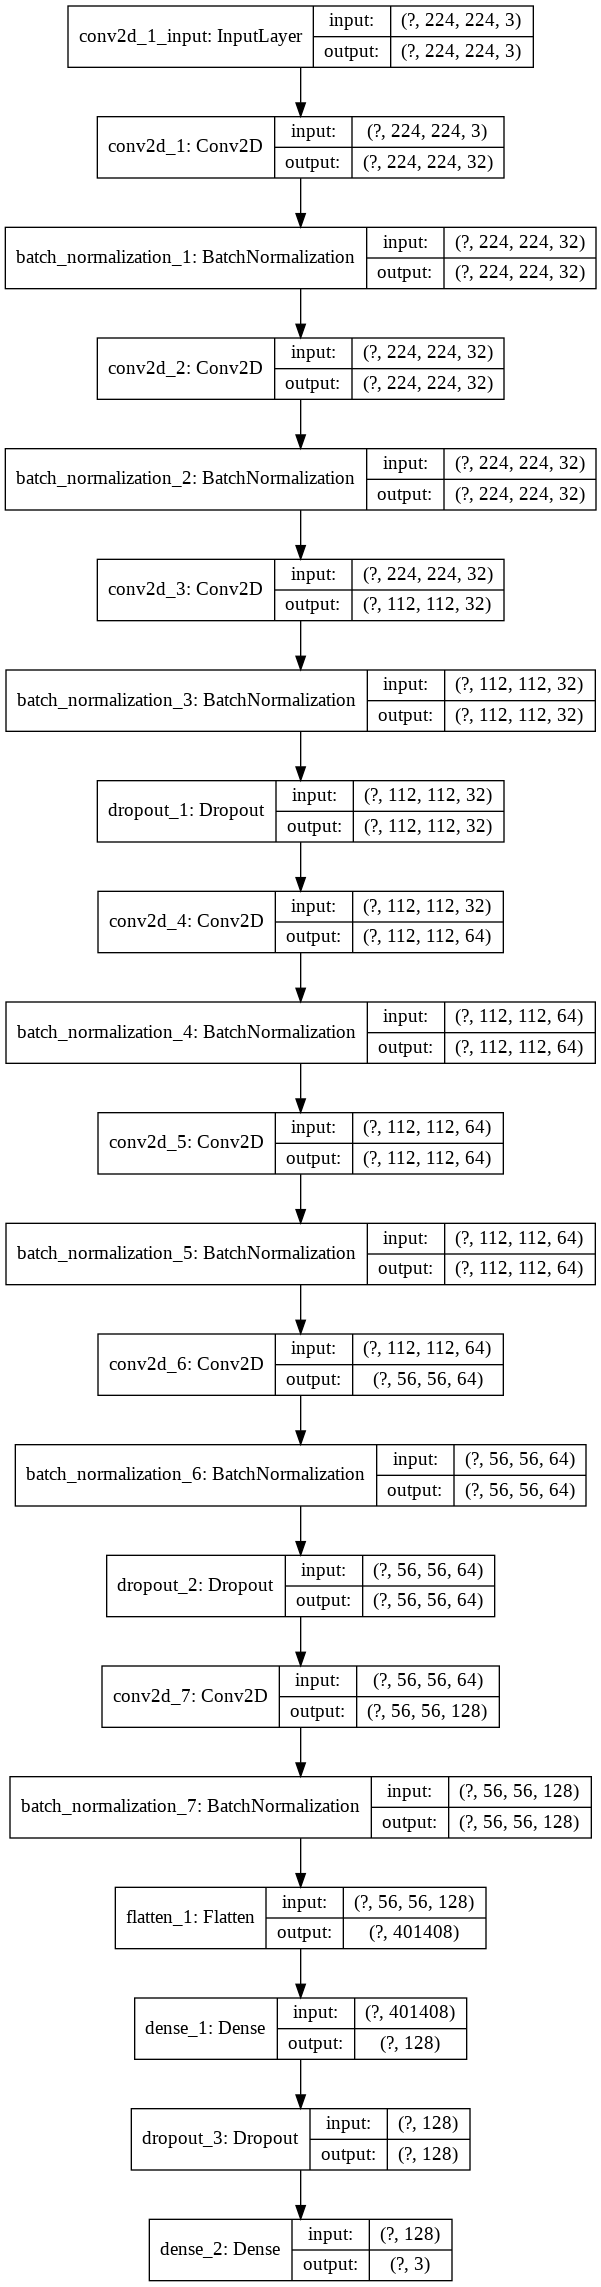

In [17]:
tf.keras.utils.plot_model(model, 'diagramaModelo.png', show_shapes=True)

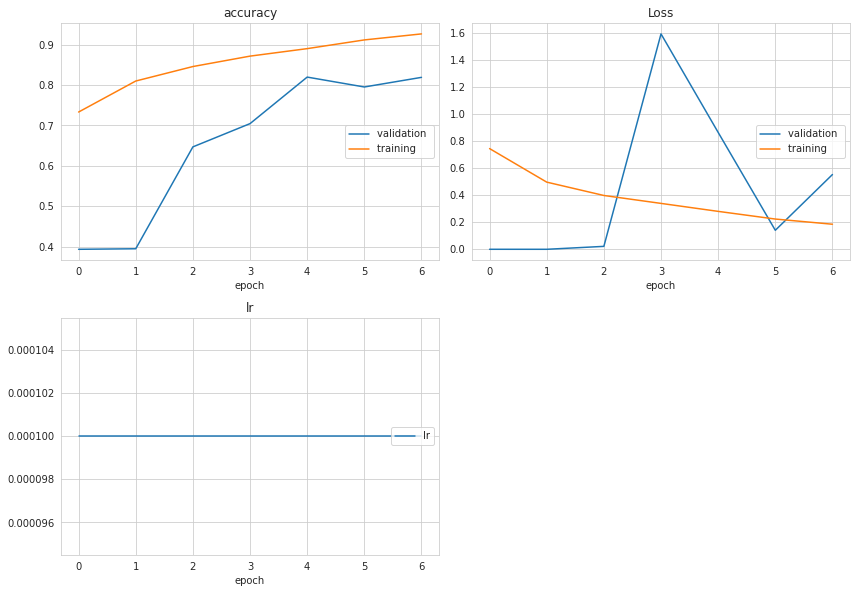

accuracy
	validation       	 (min:    0.393, max:    0.820, cur:    0.819)
	training         	 (min:    0.733, max:    0.927, cur:    0.927)
Loss
	validation       	 (min:    0.000, max:    1.592, cur:    0.553)
	training         	 (min:    0.185, max:    0.745, cur:    0.185)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00007: val_loss did not improve from 0.00006


In [18]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

epochs = 30

path="/content/drive/My Drive/covid_runs/lenet/"

os.makedirs(path,exist_ok=True)
json_model = model.to_json()
with open(path+"modelLenet.json", "w") as json_file:
  json_file.write(json_model)


reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, early_stop, checkpoint]




datasetTrainingLength=4961 
datasetValidationLength=1510


history = model.fit_generator(
    train_set,
    epochs = epochs,
    validation_data=test_set,
    callbacks=callbacks

)


model.save_weights(path + "last_run.hdf5")
model.save(path + "model")

In [19]:

resultado = []
resultado.append(model.evaluate(test_set)) 

48/48 [==============================] - 21s 437ms/step


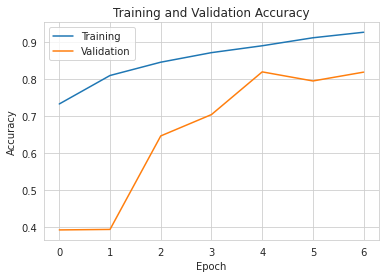

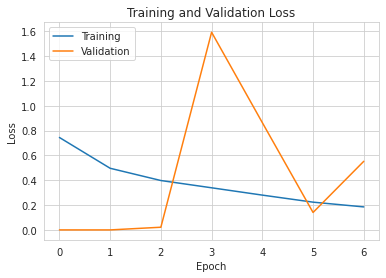

<Figure size 432x288 with 0 Axes>

In [21]:
# Summarize History for Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig(path + "accuracy.png")

# Summarize History for Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig(path + "loss.png")

In [22]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/lenet/modelLenet.json", "/content/drive/My Drive/covid_runs/lenet/last_run.hdf5")
model_cloud.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)     

In [23]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [0]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [37]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.50      0.26      0.34        31
      Normal       0.79      0.95      0.87       885
   Pneumonia       0.89      0.65      0.75       594

    accuracy                           0.82      1510
   macro avg       0.73      0.62      0.65      1510
weighted avg       0.83      0.82      0.81      1510



Text(0, 0.5, 'Ground truth')

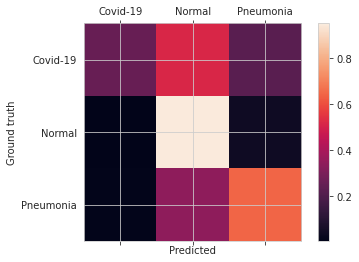

In [39]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')
